In [1]:
import numpy as np
import rebound as rb

# Surface of section
This example uses `rebound` to create a [Poincare surface of section](https://en.wikipedia.org/wiki/Poincaré_map) of the restricted circular three body problem (RC3BP). First, a series of RC3BP simulations with test particles at different semi-major axes are initialized at a fixed value of the [Jacobi constant](https://en.wikipedia.org/wiki/Jacobi_integral). Then, each simulation is integrated and the state of the test particle is recorded whenever the test particle and perturber are at opposition, i.e., $\lambda - \lambda_\mathrm{p} = \pi$ where $\lambda$ and $\lambda_\mathrm{p}$ are the mean longitudes of the test particle and massive perturber, respectively. Finally, a surface of section showing the particles' periods versus mean anomalies is plotted. Numerous resonant islands are visible at period ratios corresponding to mean motion resonances between the particle and perturber.


In [2]:
def get_sim(m_pert,n_pert,a_tp,l_pert,l_tp,e_tp,pomega_tp):
    sim = rb.Simulation()
    sim.add(m=1)
    P_pert = 2 * np.pi / n_pert
    sim.add(m=m_pert,P=P_pert,l=l_pert)
    sim.add(m=0.,a = a_tp,l=l_tp,e=e_tp,pomega=pomega_tp)
    sim.move_to_com()
    return sim

Calculate the synodic angle, $\psi = \lambda - \lambda_p$, at a specified time `T` from a simluation, `sim`.

In [3]:
def get_psi(T,sim):
    ps = sim.particles
    sim.integrate(T)
    return np.mod(ps[1].l - ps[2].l ,2*np.pi)

Calculate the Jacobi constant of the test particle,
$$
C_J = n_p l_z - |\pmb{v}|^2 -\frac{Gm_*}{|\pmb{r}-\pmb{r_*}|}-\frac{Gm_p}{|\pmb{r}-\pmb{r_p}|}
$$
where $l_z$ is the component of the test particle's specific angular momentum aligned with perturber's orbit normal.

In [4]:
def get_jacobi_const(sim):
    ps = sim.particles
    star = ps[0]
    planet = ps[1]
    particle = ps[2]
    rstar = np.array(star.xyz)
    rplanet = np.array(planet.xyz)
    r = np.array(particle.xyz)
    v = np.array(particle.vxyz)
    
    KE = 0.5 * v@v # test particle kinetic energy
    mu1 = sim.G * star.m
    mu2 = sim.G * planet.m
    r1 = r-rstar
    r2 = r-rplanet
    PE = -1*mu1/np.sqrt(r1@r1) - mu2/np.sqrt(r2@r2) # test particle potential energy
    
    lz = np.cross(r,v)[-1]
    
    CJ = 2 * planet.n * lz - 2 * (KE + PE) # jacobi constant
    return CJ
    

Plot settings

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size']=16
rcParams['axes.linewidth'] = 2
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['xtick.major.size'] = 8
rcParams['ytick.major.size'] = 8
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

# Run simulations

Set the parameters of the simulations

In [6]:
m_pert = 3e-5
n_pert = 5/4 * (1+0.05)
e_tp = 0.0
l_tp = 0
l_pert = 0
pomega_tp = 0.5 * np.pi

Given a semi-major axis value, `a`, solve for the eccentricity such that the Jacobi constant is equal to the user-specified value `CJ`. The eccentricity solution is assumed to lie in the interval specified by `e_bracket`. After finding a solution, initialize and return a simulation with a test particle with the desired semi-major axis/eccentricity combination.

In [7]:
from scipy.optimize import root_scalar
def get_sim_at_fixed_CJ(a,CJ,e_bracket):
    get_sim_fn = lambda e,a: get_sim(m_pert,n_pert,a,l_pert,l_tp,e,pomega_tp)
    root_fn = lambda e,a: get_jacobi_const(get_sim_fn(e,a)) - CJ
    root = root_scalar(root_fn,args=(a,),bracket=e_bracket)
    assert root.converged, "Root-finding failed to converge for a={:.1f}, CJ={:.1f}".format(a,CJ)
    return get_sim_fn(root.root,a)

In [8]:
def get_sos_data(sim,Npts,psi_section = np.pi):
    ps = sim.particles
    n_syn = ps[1].n - ps[2].n
    Tsyn = 2 * np.pi / n_syn
    n,e,M = np.zeros((3,Npts))
    for i in range(Npts):
        try:
            rt=root_scalar(lambda t: get_psi(t,sim) - psi_section , bracket=[sim.t + 0.8*Tsyn,sim.t + 1.2*Tsyn])
        except:
            # re-compute Tsyn
            n_syn = ps[1].n - ps[2].n
            Tsyn = 2*np.pi/n_syn
            rt=root_scalar(lambda t: get_psi(t,sim) - psi_section , bracket=[sim.t + 0.8*Tsyn,sim.t + 1.2*Tsyn])
        n[i] = ps[2].n
        e[i] = ps[2].e
        M[i] = ps[2].M
    return n,e,M

In [9]:
a_tp0 = 1
sim0 = get_sim(m_pert,n_pert,a_tp0,l_pert,l_tp,e_tp,pomega_tp)
CJ0 = get_jacobi_const(sim0)

Nsims = 20 # Number of simulations to plot on surface of section
Npts = 100 # Number of points to plot per simulation

da_vals = np.linspace(0,0.1,Nsims)
sims = [get_sim_at_fixed_CJ(a_tp0 + da,CJ0,[0,0.3]) for da in da_vals]



In [10]:
all_pts = np.array([get_sos_data(sim,Npts) for sim in sims])

/Users/shadden/anaconda/envs/celmech/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


The surface of section points are plotted below, along with the values of the test particles' eccentricities over the range of period ratio displayed in the surface of section.

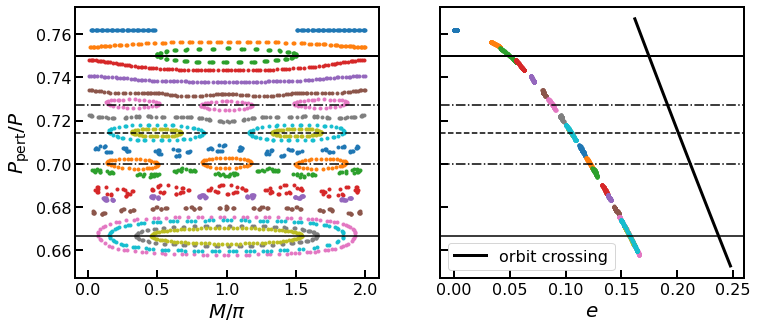

In [11]:
fig,ax = plt.subplots(1,2,sharey=True,figsize=(12,5))

min_pratio=0 
max_pratio=np.inf
for n,e,M in all_pts:
    n_tp = n
    alpha = (n/n_pert)**(2/3)
    ecross = 1-alpha
    ax[0].plot(M / np.pi, n/n_pert,'.')
    ax[1].plot(e, n/n_pert,'.')

# plot the orbit-crossing eccentricity for reference
# versus period ratio
pratios = np.linspace(*ax[0].get_ylim())
alpha = pratios**(2/3)
ecross=1-alpha
ax[1].plot(ecross,pratios,'k-',lw=3,label="orbit crossing")
ax[1].legend()

ax[0].set_ylabel(r"$P_\mathrm{pert}/P$",fontsize=20)
ax[0].set_xlabel(r"$M/\pi$",fontsize=20)

ax[1].set_xlabel(r"$e$",fontsize=20)

# plot the location of some resonances
for a in ax:
    a.axhline(3/4,ls='-',color='k',lw=2) # 1st order mmr
    a.axhline(8/11,ls='-.',color='k') # 3rd order mmr
    a.axhline(5/7,ls='--',color='k') # 2nd order mmr
    a.axhline(7/10,ls='-.',color='k') # 3rd order mmr
    a.axhline(2/3,ls='-',color='k') # first order mmr